<a href="https://colab.research.google.com/github/betyavan/ML-practice/blob/main/classification_simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine tuning сверточной сети ResNet-152 для классификации персонажей из мультсериала Симпсоны. Датасет взят из kaggle



## Загрузка датасета

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download journey-springfield


 99% 517M/521M [00:06<00:00, 111MB/s] 
100% 521M/521M [00:06<00:00, 79.7MB/s]


In [8]:
!unzip -q journey-springfield.zip

## Необходимые импорты

In [9]:
import PIL

In [10]:
import torch

In [11]:
import pickle
import numpy as np
from skimage import io

from tqdm.autonotebook import tqdm, trange
from PIL import Image
from pathlib import Path

from torchvision import transforms, models, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

## Формируем и обрабатывем датасет

In [12]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
device

'cuda'

In [14]:
class SimpsonsDataset(Dataset):

  def __init__(self, files, mode):
    super(SimpsonsDataset, self).__init__()
    self.files = sorted(files)
    self.mode = mode

    if self.mode not in DATA_MODES:
      print(f'{self.mode} is not correct; correct modes: {DATA_MODES}')
      raise NameError
    
    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', "wb") as le_dump_file:
        pickle.dump(self.label_encoder, le_dump_file)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image
  
  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

  def __getitem__(self, index):
    transform = transforms.Compose([
        #transforms.RandomResizedCrop(RESCALE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    x = np.array(x / 255, dtype='float32')
    x = transform(x)
    if self.mode == 'test':
      return x
    else:
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False): # for Tensors
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt_ax.imshow(inp)
  if title is not None:
    plt_ax.set_title(title)
  plt_ax.grid(False)

In [16]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [17]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2,
                                          stratify=train_val_labels)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
#from google.colab import output
#output.disable_custom_widget_manager()

In [18]:
modes = ['train', 'val']
files = {'train': train_files,
         'val': val_files}   
datasets = {x: SimpsonsDataset(files[x], mode=x) for x in modes} 
datasets_sizes = {x: len(datasets[x]) for x in modes}  

In [19]:
datasets_sizes

{'train': 16746, 'val': 4187}

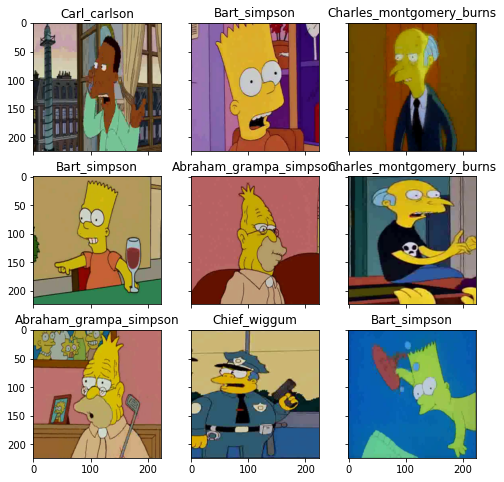

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)
for fig_ax in ax.flatten():
  random_ch = int(np.random.uniform(0, 1000))
  im_val, label = datasets['val'][random_ch]
  img_label = " ".join(map(lambda x: x.capitalize(),
                           datasets['val'].label_encoder.inverse_transform([label])))
  imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_ax)

## Функция обучения

In [21]:
def train_model(model, loss_fn, optim, batch_size=128, num_epochs=5):

  dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size,
                                shuffle=True, num_workers=2)
                  for x in modes}
  best_model_wts = model.state_dict()
  best_acc = 0.0

  losses = {x: [] for x in modes}

  pbar = trange(num_epochs, desc='Epoch:')

  for epoch in pbar:
    print(f"Epoch: {epoch}")
    for phase in modes:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0

      for inp, labels in tqdm(dataloaders[phase], leave=False,
                              desc=f'{phase} iter: '):
        inp = inp.to(device)
        labels = labels.to(device)

        if phase == 'train':
          optim.zero_grad()

        if phase == 'val':
          with torch.no_grad():
            outp = model(inp)
        else:
          outp = model(inp)
        
        preds = torch.argmax(outp, -1)
        loss = loss_fn(outp, labels)

        if phase == 'train':
          loss.backward()
          optim.step()

        running_loss += loss.item()
        running_correct += int(torch.sum(preds == labels.data))

      epoch_loss = running_loss / datasets_sizes[phase]
      epoch_acc = running_correct / datasets_sizes[phase]

      losses[phase].append(epoch_loss)

      #pbar.set_description('%5s Loss: %.3f Acc: %.3f' % (phase, epoch_loss, epoch_acc))
      print('%5s Loss: %.3f Acc: %.3f' % (phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()
  print('Best val Acc: %0.4f' % (best_acc))
  model.load_state_dict(best_model_wts)
  return model, losses

In [22]:
def predict(model, test_loader):
  model.eval()
  with torch.no_grad():
    logits = []
    for inputs in test_loader:
      inputs = inputs.to(device)
      outp = model(inputs).cpu()
      logits.append(outp)
  probs = nn.functional.softmax(torch.cat(logits), -1).numpy()
  return probs

## Модель

In [23]:
n_classes = len(np.unique(train_val_labels))

In [24]:
n_classes

42

In [25]:
model = models.resnet152(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [26]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
for param in model.parameters():
  param.requires_grad = False

In [28]:
for layer in [model.layer3, model.layer4, model.avgpool]:
  for param in layer.parameters():
    param.requires_grad = True

In [29]:
model.fc = nn.Linear(2048, n_classes)

In [30]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(list(model.layer3.parameters()) + list(model.layer4.parameters()) +
                         list(model.avgpool.parameters()) + list(model.fc.parameters()), lr=3e-4)

## обучение модели

In [31]:
%%time

model, losses = train_model(model, criterion, optim)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


train iter:   0%|          | 0/131 [00:00<?, ?it/s]

train Loss: 0.004 Acc: 0.872


val iter:   0%|          | 0/33 [00:00<?, ?it/s]

  val Loss: 0.002 Acc: 0.928
Epoch: 1


train iter:   0%|          | 0/131 [00:00<?, ?it/s]

train Loss: 0.001 Acc: 0.963


val iter:   0%|          | 0/33 [00:00<?, ?it/s]

  val Loss: 0.002 Acc: 0.934
Epoch: 2


train iter:   0%|          | 0/131 [00:00<?, ?it/s]

train Loss: 0.001 Acc: 0.983


val iter:   0%|          | 0/33 [00:00<?, ?it/s]

  val Loss: 0.002 Acc: 0.947
Epoch: 3


train iter:   0%|          | 0/131 [00:00<?, ?it/s]

train Loss: 0.000 Acc: 0.989


val iter:   0%|          | 0/33 [00:00<?, ?it/s]

  val Loss: 0.001 Acc: 0.955
Epoch: 4


train iter:   0%|          | 0/131 [00:00<?, ?it/s]

train Loss: 0.000 Acc: 0.989


val iter:   0%|          | 0/33 [00:00<?, ?it/s]

  val Loss: 0.002 Acc: 0.938
Best val Acc: 0.9546
CPU times: user 14min 23s, sys: 13min 12s, total: 27min 35s
Wall time: 29min 11s


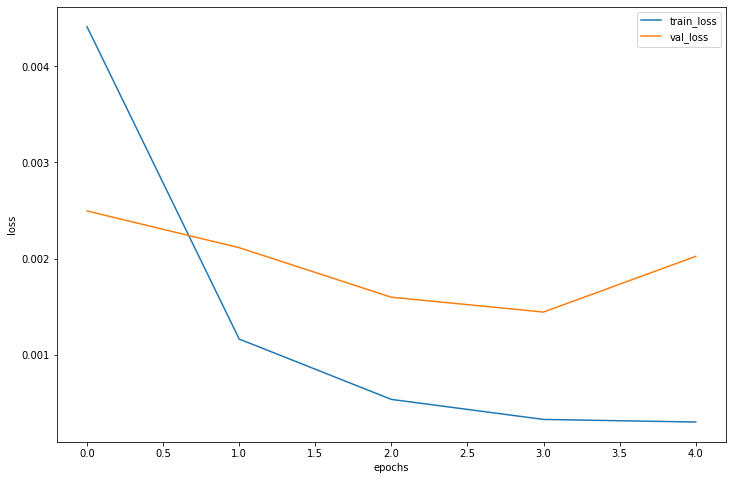

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label='train_loss')
plt.plot(losses['val'], label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss');

## Получаем результаты

In [34]:
def predict_one_sample(model, inp):
  with torch.no_grad():
    inp = inp.to(device)
    model.eval()
    logit = model(inp).cpu()
    probs = torch.nn.functional.softmax(logit, -1).numpy()
  return probs

In [35]:
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = datasets['val'][random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [36]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [datasets['val'][id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [37]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [38]:
y_pred = np.argmax(probs_ims, -1)

actual_labels = [label_encoder.classes_[datasets['val'][id][1]] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [39]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')

0.9500000000000001

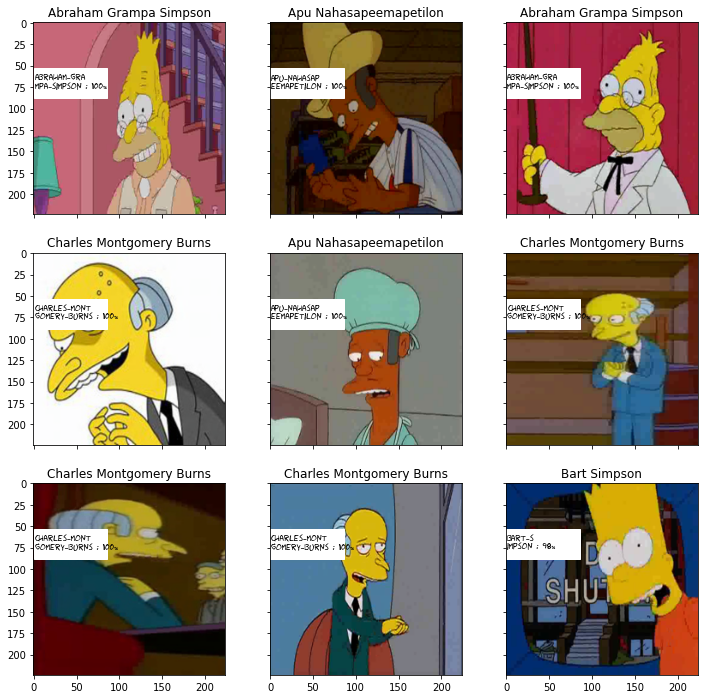

In [40]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = datasets['val'][random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [41]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [42]:
import pandas as pd
#my_submit = pd.read_csv("labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [43]:
my_submit.to_csv('my_submission.csv', index=False)